In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!ls /content/drive/MyDrive/data/train

A  B  label


In [ ]:
import os
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

def process_image_pair(args):
    filename_a, filename_b, filename_label = args
    img1_path = os.path.join(folder_a_path, filename_a)
    img1 = load_image_cv(img1_path)

    img2_path = os.path.join(folder_b_path, filename_b)
    img2 = load_image_cv(img2_path)

    gt_image_path = os.path.join(label_path, filename_label)
    gt_image = io.imread(gt_image_path)

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

    descriptors1_float = descriptors1.astype(np.float32)
    descriptors2_float = descriptors2.astype(np.float32)

    matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.85 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(registered_img_gray, 200, 585)
        edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

        kernel = np.ones((5, 5), np.uint8)
        dilated_edges = cv2.dilate(edges, kernel, iterations=1)

        binary_change_map = dilated_edges > 0

        ssim_index = ssim(registered_img_gray, gt_image)
        mse_value = mse(registered_img_gray, gt_image)

        return ssim_index, mse_value

    else:
        return None, None

base_dir = '/content/drive/MyDrive/data/train'
folder_a_path = os.path.join(base_dir, 'A')
folder_b_path = os.path.join(base_dir, 'B')
label_path = os.path.join(base_dir, 'label')

folder_a_images = os.listdir(folder_a_path)
folder_b_images = os.listdir(folder_b_path)
label_images = os.listdir(label_path)

brisk = cv2.BRISK_create()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=3)
search_params = dict(checks=70)
flann = cv2.FlannBasedMatcher(index_params, search_params)

ssim_scores = []
mse_scores = []

# Create pool for multiprocessing
pool = Pool()

# Iterate through each image pair
for ssim_score, mse_score in pool.imap_unordered(process_image_pair, zip(folder_a_images, folder_b_images, label_images)):
    if ssim_score is not None:
        ssim_scores.append(ssim_score)
        mse_scores.append(mse_score)
    else:
        print("Not enough matches for an image pair.")

pool.close()
pool.join()

mean_ssim = np.mean(ssim_scores)
mean_mse = np.mean(mse_scores)

print(f"Mean SSIM score: {mean_ssim}")
print(f"Mean MSE score: {mean_mse}")


Mean SSIM score: 0.5640759898926236
Mean MSE score: 5522.87980848591


brisk canny

SSIM: 0.7612054559228073
MSE: 8485.322345114082


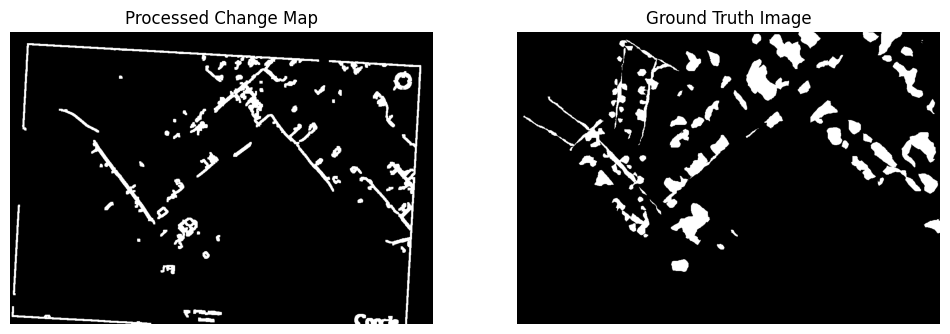

In [ ]:
import cv2
import numpy as np
from skimage import io, filters
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize BRISK detector
brisk = cv2.BRISK_create()

# Find the keypoints and descriptors with BRISK
keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

# Convert BRISK descriptors to floating-point format
descriptors1_float = descriptors1.astype(np.float32)
descriptors2_float = descriptors2.astype(np.float32)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=3)
search_params = dict(checks=70)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Sobel operator to detect edges
    edges = cv2.Canny(registered_img_gray, 200, 585)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


brisk - sobel

SSIM: 0.8281628073071367
MSE: 5782.872149266163


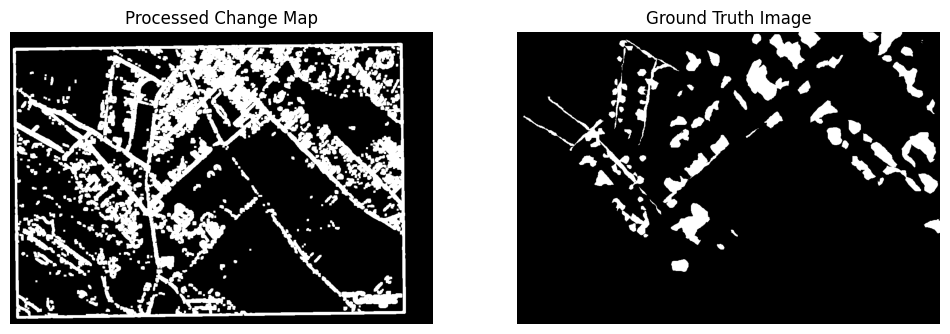

In [ ]:
import cv2
import numpy as np
from skimage import io, filters
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize BRISK detector
brisk = cv2.BRISK_create()

# Find the keypoints and descriptors with BRISK
keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

# Convert BRISK descriptors to floating-point format
descriptors1_float = descriptors1.astype(np.float32)
descriptors2_float = descriptors2.astype(np.float32)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=7)
search_params = dict(checks=40)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.80 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Sobel operator to detect edges
    sobel_x = cv2.Sobel(registered_img_gray, cv2.CV_64F, 1, 0, ksize=7)
    sobel_y = cv2.Sobel(registered_img_gray, cv2.CV_64F, 0, 1, ksize=7)
    edges_sobel = np.sqrt(sobel_x**2 + sobel_y**2)

    # Apply threshold to get binary map of edges
    edges_binary = (edges_sobel > np.percentile(edges_sobel, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


BRISK - PREWITT

SSIM: 0.8356821878742061
MSE: 5783.1562381384165


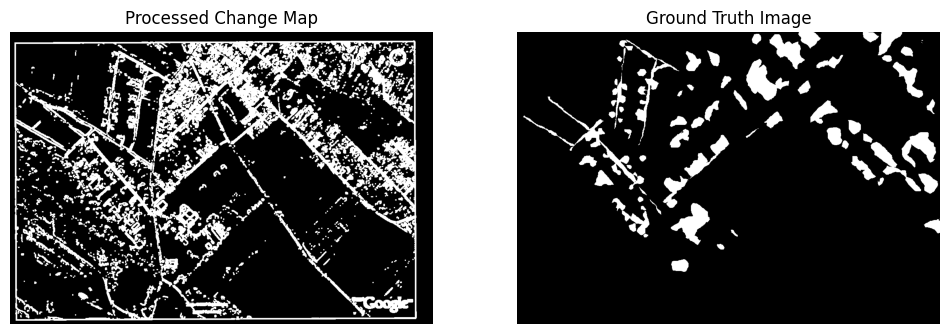

In [ ]:
import cv2
import numpy as np
from skimage import io, filters
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import prewitt
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize BRISK detector
brisk = cv2.BRISK_create()

# Find the keypoints and descriptors with BRISK
keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

# Convert BRISK descriptors to floating-point format
descriptors1_float = descriptors1.astype(np.float32)
descriptors2_float = descriptors2.astype(np.float32)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)
search_params = dict(checks=80)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.90 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Prewitt operator to detect edges
    edges = prewitt(registered_img_gray)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


BRISK-LOG

SSIM: 0.833547134104839
MSE: 5781.634999314664


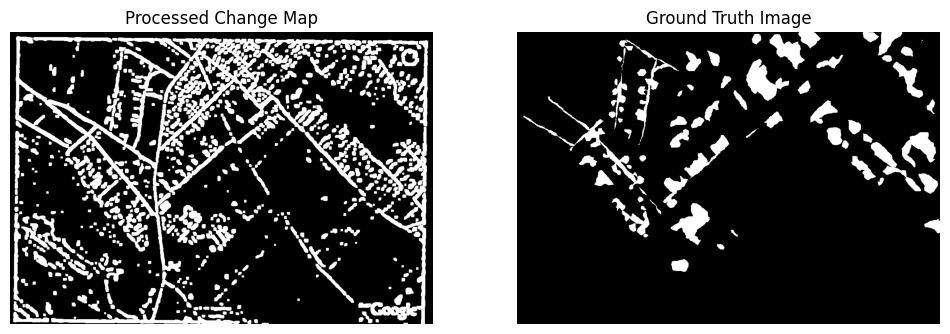

In [ ]:
import cv2
import numpy as np
from skimage import io, filters, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import gaussian, laplace
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize BRISK detector
brisk = cv2.BRISK_create()

# Find the keypoints and descriptors with BRISK
keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

# Convert BRISK descriptors to floating-point format
descriptors1_float = descriptors1.astype(np.float32)
descriptors2_float = descriptors2.astype(np.float32)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the image
    blurred_img = gaussian(registered_img_gray, sigma=3)

    # Use Laplacian filter to detect edges
    edges = laplace(blurred_img)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


BRISK-SCHAAR

SSIM: 0.8384904698231264
MSE: 5773.227509120239


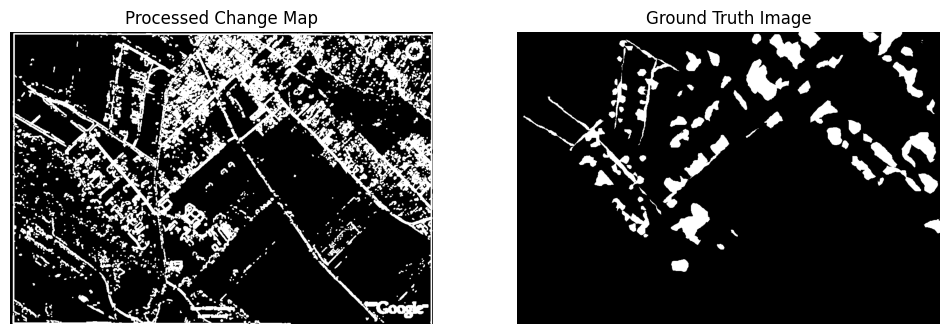

In [ ]:
import cv2
import numpy as np
from skimage import io, filters, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import gaussian, scharr
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize BRISK detector
brisk = cv2.BRISK_create()

# Find the keypoints and descriptors with BRISK
keypoints1, descriptors1 = brisk.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = brisk.detectAndCompute(img2_gray, None)

# Convert BRISK descriptors to floating-point format
descriptors1_float = descriptors1.astype(np.float32)
descriptors2_float = descriptors2.astype(np.float32)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1_float, descriptors2_float, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.90 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Scharr operator to detect edges
    edges = scharr(registered_img_gray)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


Canny Edge Detection Algorithm

SSIM: 0.7779673960932947
MSE: 7573.217895966008


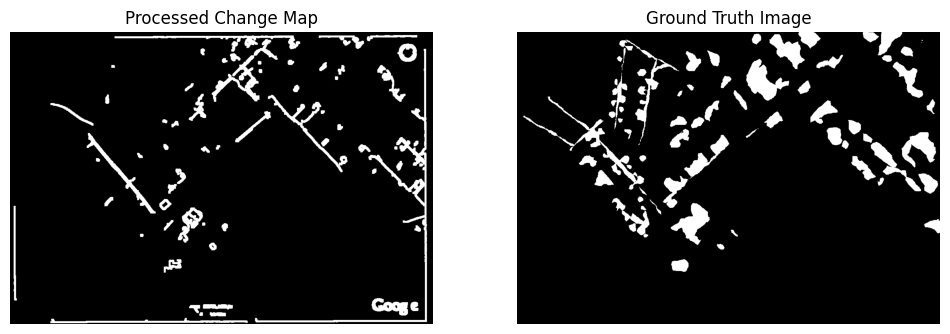

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=3)
search_params = dict(checks=70)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Sobel operator to detect edges
    edges = cv2.Canny(registered_img_gray, 200, 585)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


SOBEL

SSIM: 0.8309437315924346
MSE: 5773.35847022479


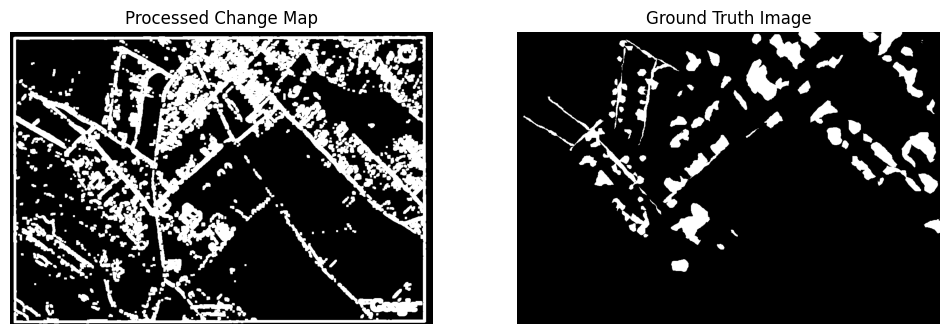

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=7)
search_params = dict(checks=40)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.80 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Sobel operator to detect edges
    sobel_x = cv2.Sobel(registered_img_gray, cv2.CV_64F, 1, 0, ksize=7)
    sobel_y = cv2.Sobel(registered_img_gray, cv2.CV_64F, 0, 1, ksize=7)
    edges_sobel = np.sqrt(sobel_x**2 + sobel_y**2)

    # Apply threshold to get binary map of edges
    edges_binary = (edges_sobel > np.percentile(edges_sobel, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


PREWITT

SSIM: 0.8391404272630861
MSE: 5772.760434239382


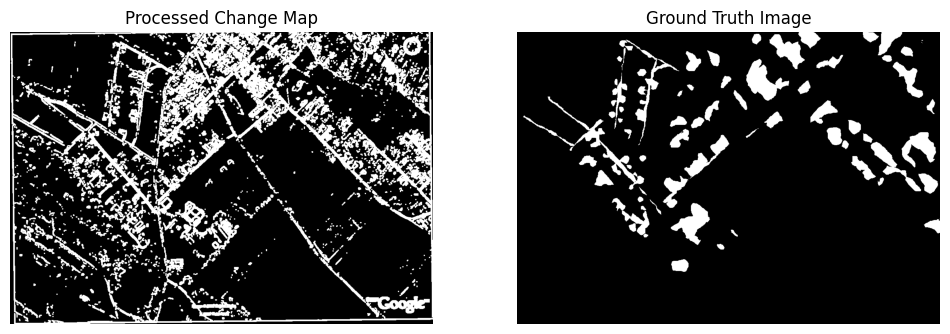

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel, prewitt
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)
search_params = dict(checks=80)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.90 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Prewitt operator to detect edges
    edges = prewitt(registered_img_gray)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


LOG

SSIM: 0.8357134938226642
MSE: 5774.744883703766


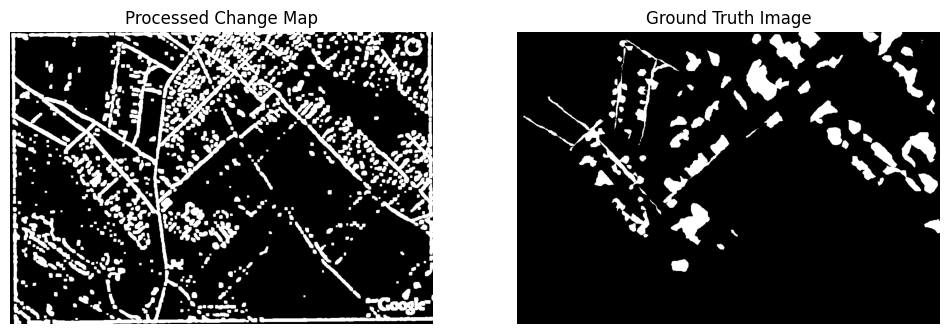

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel, gaussian, laplace
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the image
    blurred_img = gaussian(registered_img_gray, sigma=3)

    # Use Laplacian filter to detect edges
    edges = laplace(blurred_img)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((5, 5), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


Scharr Operator

SSIM: 0.8342112745208495
MSE: 5779.212518714942


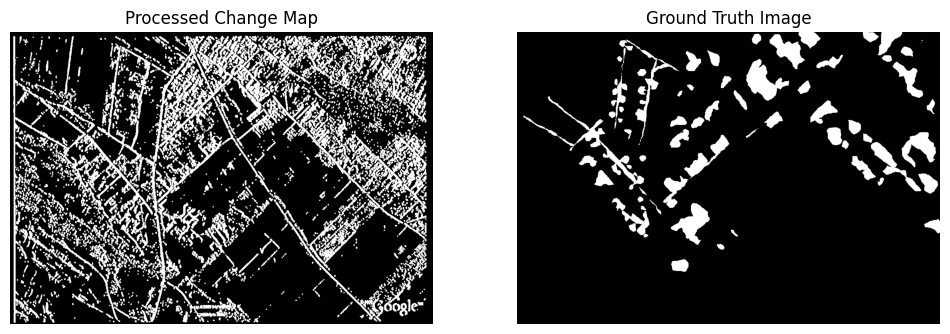

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.90 * n.distance:
        good_matches.append(m)

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros_like(points1)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Use Scharr operator to detect edges
    edges = cv2.Scharr(registered_img_gray, cv2.CV_64F, 1, 0)

    # Apply threshold to get binary map of edges
    edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

    # Dilate the edges to make them more prominent
    # Increase the kernel size to dilate major edges more
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

    # Threshold the dilated edges to create a binary map that includes only major details
    binary_change_map = dilated_edges > 0

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(dilated_edges, gt_image)
    mse_value = mse(dilated_edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(dilated_edges, cmap='gray')
    ax[0].set_title('Processed Change Map')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


LATCH-CANNY


SSIM: 0.7911257558523181
MSE: 7083.8712451499305
Latching successful!


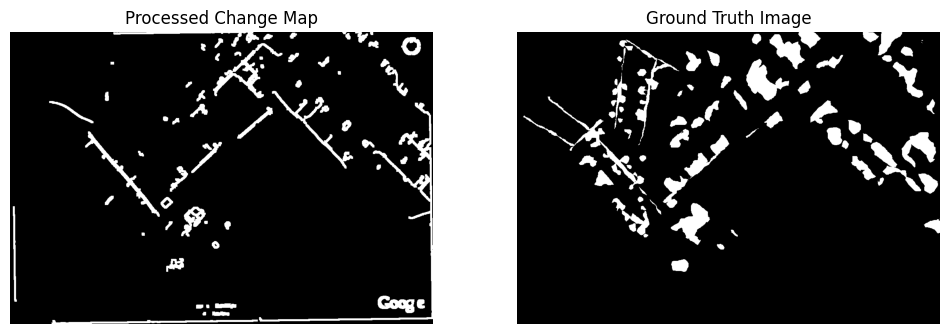

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

latch = False
while not latch:
    # Find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=3)
    search_params = dict(checks=70)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.85 * n.distance:
            good_matches.append(m)

    # Ensure that sufficient matches are found
    if len(good_matches) > 10:
        # Extract location of good matches
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find affine transformation
        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        # Warp image using affine transformation
        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        # Convert warped image to grayscale
        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        # Use Sobel operator to detect edges
        edges = cv2.Canny(registered_img_gray, 200, 585)

        # Apply threshold to get binary map of edges
        edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

        # Dilate the edges to make them more prominent
        # Increase the kernel size to dilate major edges more
        kernel = np.ones((5, 5), np.uint8)
        dilated_edges = cv2.dilate(edges, kernel, iterations=1)

        # Threshold the dilated edges to create a binary map that includes only major details
        binary_change_map = dilated_edges > 0

        # Compute SSIM and MSE with ground truth
        ssim_index = ssim(dilated_edges, gt_image)
        mse_value = mse(dilated_edges, gt_image)

        print(f"SSIM: {ssim_index}")
        print(f"MSE: {mse_value}")

        # Check if SSIM meets a certain threshold for latch condition
        if ssim_index > 0.7879:
            latch = True
            print("Latching successful!")
            # Display the processed change map and the ground truth image
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(dilated_edges, cmap='gray')
            ax[0].set_title('Processed Change Map')
            ax[0].axis('off')
            ax[1].imshow(gt_image, cmap='gray')
            ax[1].set_title('Ground Truth Image')
            ax[1].axis('off')
            plt.show()
        else:
            print("SSIM threshold not met, retrying...")
    else:
        print("Not enough matches - at least 10 matches required, only found", len(good_matches))


LATCH-SOBEL

SSIM: 0.8310189201610194
MSE: 5773.164310604782
Latching successful!


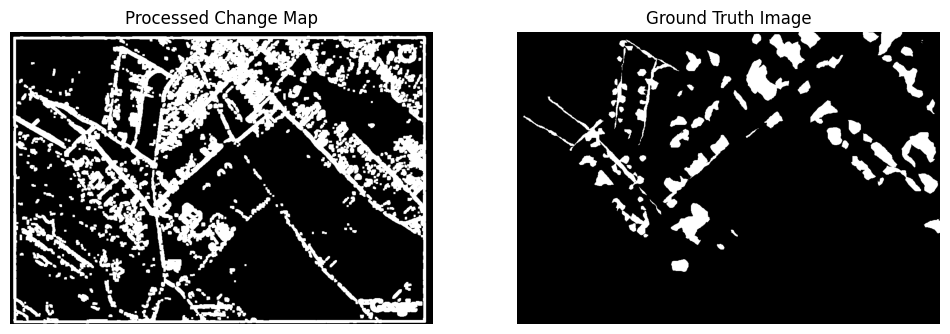

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import sobel
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

latch = False
while not latch:
    # Find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=7)
    search_params = dict(checks=40)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.80 * n.distance:
            good_matches.append(m)

    # Ensure that sufficient matches are found
    if len(good_matches) > 10:
        # Extract location of good matches
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find affine transformation
        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        # Warp image using affine transformation
        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        # Convert warped image to grayscale
        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        # Use Sobel operator to detect edges
        sobel_x = cv2.Sobel(registered_img_gray, cv2.CV_64F, 1, 0, ksize=7)
        sobel_y = cv2.Sobel(registered_img_gray, cv2.CV_64F, 0, 1, ksize=7)
        edges_sobel = np.sqrt(sobel_x**2 + sobel_y**2)

        # Apply threshold to get binary map of edges
        edges_binary = (edges_sobel > np.percentile(edges_sobel, 90)).astype(np.uint8)

        # Dilate the edges to make them more prominent
        # Increase the kernel size to dilate major edges more
        kernel = np.ones((5, 5), np.uint8)
        dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

        # Threshold the dilated edges to create a binary map that includes only major details
        binary_change_map = dilated_edges > 0

        # Compute SSIM and MSE with ground truth
        ssim_index = ssim(dilated_edges, gt_image)
        mse_value = mse(dilated_edges, gt_image)

        print(f"SSIM: {ssim_index}")
        print(f"MSE: {mse_value}")

        # Check if SSIM meets a certain threshold for latch condition
        if ssim_index > 0.8:
            latch = True
            print("Latching successful!")
            # Display the processed change map and the ground truth image
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(dilated_edges, cmap='gray')
            ax[0].set_title('Processed Change Map')
            ax[0].axis('off')
            ax[1].imshow(gt_image, cmap='gray')
            ax[1].set_title('Ground Truth Image')
            ax[1].axis('off')
            plt.show()
        else:
            print("SSIM threshold not met, retrying...")
    else:
        print("Not enough matches - at least 10 matches required, only found", len(good_matches))


LATCH-PREWITT

Enough good matches found. Latching successful!
SSIM: 0.8375417891142604
MSE: 5777.220981295602


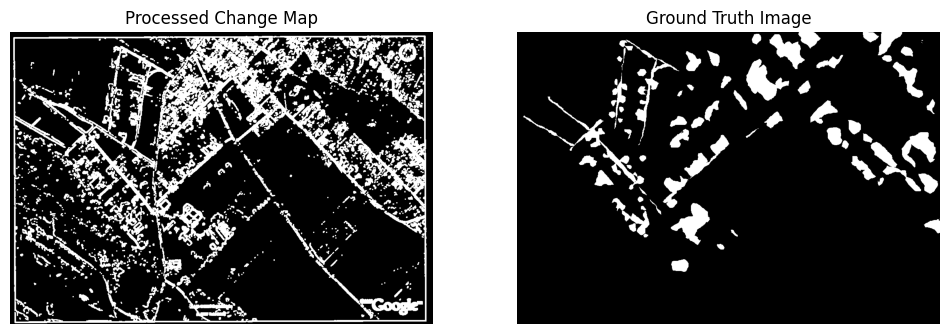

In [ ]:
import cv2
import numpy as np
from skimage import io, color, filters, morphology, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import prewitt
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Set latch condition
latch = False

while not latch:
    # Find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=4)
    search_params = dict(checks=80)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.90 * n.distance:
            good_matches.append(m)

    # Check if there are enough good matches
    if len(good_matches) > 10:
        latch = True
        print("Enough good matches found. Latching successful!")
        # Extract location of good matches
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find affine transformation
        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        # Warp image using affine transformation
        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        # Convert warped image to grayscale
        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        # Use Prewitt operator to detect edges
        edges = prewitt(registered_img_gray)

        # Apply threshold to get binary map of edges
        edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

        # Dilate the edges to make them more prominent
        # Increase the kernel size to dilate major edges more
        kernel = np.ones((3,3), np.uint8)
        dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

        # Threshold the dilated edges to create a binary map that includes only major details
        binary_change_map = dilated_edges > 0

        # Compute SSIM and MSE with ground truth
        ssim_index = ssim(dilated_edges, gt_image)
        mse_value = mse(dilated_edges, gt_image)

        print(f"SSIM: {ssim_index}")
        print(f"MSE: {mse_value}")

        # Display the processed change map and the ground truth image
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(dilated_edges, cmap='gray')
        ax[0].set_title('Processed Change Map')
        ax[0].axis('off')
        ax[1].imshow(gt_image, cmap='gray')
        ax[1].set_title('Ground Truth Image')
        ax[1].axis('off')
        plt.show()
    else:
        print("Not enough matches - at least 10 matches required, only found", len(good_matches))
        print("Retrying...")



LATCH-LOG

Enough good matches found. Latching successful!
SSIM: 0.835687087392394
MSE: 5774.910379148918


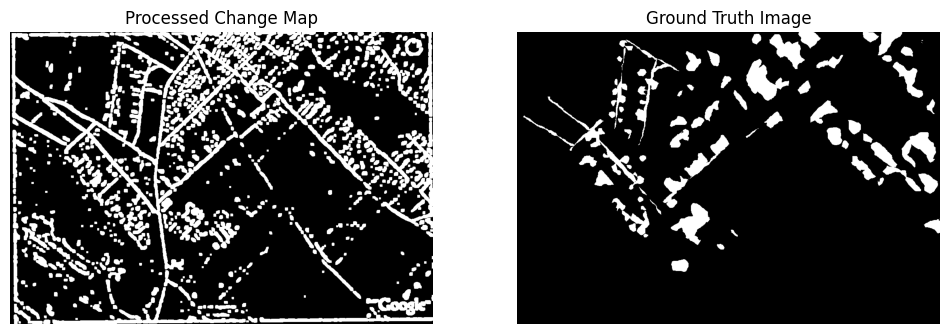

In [ ]:
import cv2
import numpy as np
from skimage import io, filters, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import gaussian, laplace
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Set latch condition
latch = False

while not latch:
    # Find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
    search_params = dict(checks=100)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.85 * n.distance:
            good_matches.append(m)

    # Check if there are enough good matches
    if len(good_matches) > 10:
        latch = True
        print("Enough good matches found. Latching successful!")

        # Extract location of good matches
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find affine transformation
        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        # Warp image using affine transformation
        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        # Convert warped image to grayscale
        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to the image
        blurred_img = gaussian(registered_img_gray, sigma=3)

        # Use Laplacian filter to detect edges
        edges = laplace(blurred_img)

        # Apply threshold to get binary map of edges
        edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

        # Dilate the edges to make them more prominent
        # Increase the kernel size to dilate major edges more
        kernel = np.ones((5, 5), np.uint8)
        dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

        # Threshold the dilated edges to create a binary map that includes only major details
        binary_change_map = dilated_edges > 0

        # Compute SSIM and MSE with ground truth
        ssim_index = ssim(dilated_edges, gt_image)
        mse_value = mse(dilated_edges, gt_image)

        print(f"SSIM: {ssim_index}")
        print(f"MSE: {mse_value}")

        # Display the processed change map and the ground truth image
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(dilated_edges, cmap='gray')
        ax[0].set_title('Processed Change Map')
        ax[0].axis('off')
        ax[1].imshow(gt_image, cmap='gray')
        ax[1].set_title('Ground Truth Image')
        ax[1].axis('off')
        plt.show()

    else:
        print("Not enough matches - at least 10 matches required, only found", len(good_matches))
        print("Retrying...")


LATCH-SCHARR

Enough good matches found. Latching successful!
SSIM: 0.8386740225151631
MSE: 5772.54025557758


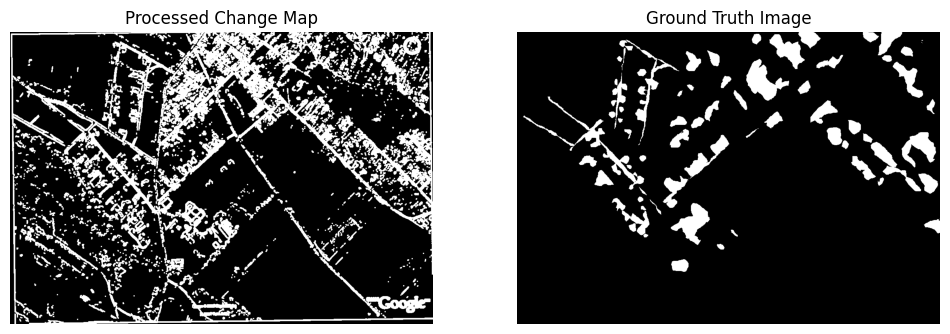

In [ ]:
import cv2
import numpy as np
from skimage import io, filters, measure
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from skimage.filters import scharr
from PIL import Image
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Set latch condition
latch = False

while not latch:
    # Find the keypoints and descriptors with SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
    search_params = dict(checks=100)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.90 * n.distance:
            good_matches.append(m)

    # Check if there are enough good matches
    if len(good_matches) > 10:
        latch = True
        print("Enough good matches found. Latching successful!")

        # Extract location of good matches
        points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
        points2 = np.zeros_like(points1)

        for i, match in enumerate(good_matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt

        # Find affine transformation
        M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

        # Warp image using affine transformation
        registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

        # Convert warped image to grayscale
        registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

        # Use Scharr operator to detect edges
        edges = scharr(registered_img_gray)

        # Apply threshold to get binary map of edges
        edges_binary = (edges > np.percentile(edges, 90)).astype(np.uint8)

        # Dilate the edges to make them more prominent
        # Increase the kernel size to dilate major edges more
        kernel = np.ones((3, 3), np.uint8)
        dilated_edges = cv2.dilate(edges_binary, kernel, iterations=1)

        # Threshold the dilated edges to create a binary map that includes only major details
        binary_change_map = dilated_edges > 0

        # Compute SSIM and MSE with ground truth
        ssim_index = ssim(dilated_edges, gt_image)
        mse_value = mse(dilated_edges, gt_image)

        print(f"SSIM: {ssim_index}")
        print(f"MSE: {mse_value}")

        # Display the processed change map and the ground truth image
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(dilated_edges, cmap='gray')
        ax[0].set_title('Processed Change Map')
        ax[0].axis('off')
        ax[1].imshow(gt_image, cmap='gray')
        ax[1].set_title('Ground Truth Image')
        ax[1].axis('off')
        plt.show()

    else:
        print("Not enough matches - at least 10 matches required, only found", len(good_matches))
        print("Retrying...")


SSIM: 0.5733609000346156
MSE: 9305.042260185146


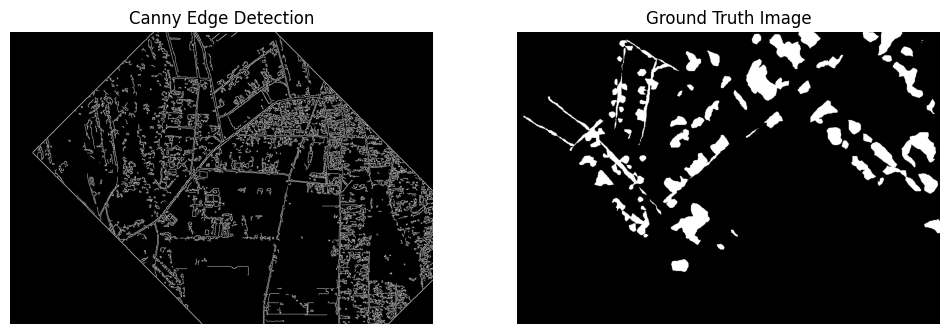

In [ ]:
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Take top 10% matches
good_matches = matches[:int(len(matches)*0.4)]

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(registered_img_gray, 100, 200)

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(edges, gt_image)
    mse_value = mse(edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(edges, cmap='gray')
    ax[0].set_title('Canny Edge Detection')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


SSIM: 0.5880325833427381
MSE: 5773.274595651807


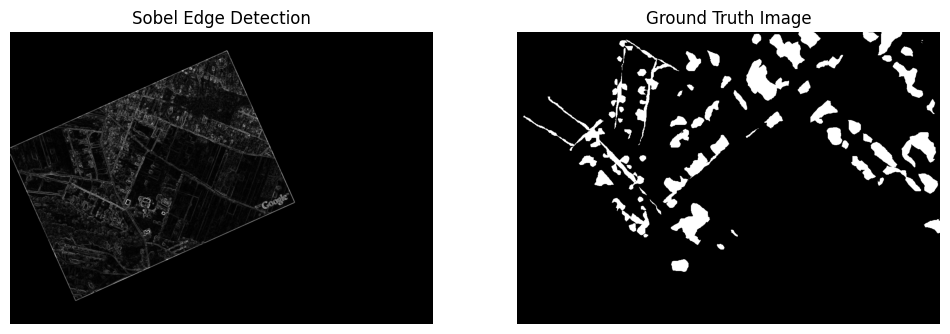

In [ ]:
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Take top 10% matches
good_matches = matches[:int(len(matches)*0.2)]

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(registered_img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(registered_img_gray, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize edges to [0, 255]
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(edges, gt_image)
    mse_value = mse(edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(edges, cmap='gray')
    ax[0].set_title('Sobel Edge Detection')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


SSIM: 0.2943649916889321
MSE: 13979.379597022478


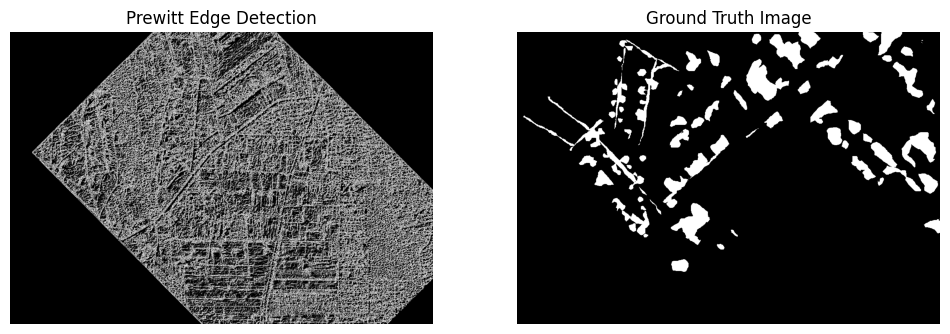

In [ ]:
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Take top 10% matches
good_matches = matches[:int(len(matches)*0.4)]

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Prewitt edge detection
    prewitt_x = cv2.filter2D(registered_img_gray, -1, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
    prewitt_y = cv2.filter2D(registered_img_gray, -1, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
    edges = np.sqrt(prewitt_x**2 + prewitt_y**2)

    # Normalize edges manually to [0, 255]
    edges = (edges - np.min(edges)) / (np.max(edges) - np.min(edges)) * 255
    edges = edges.astype(np.uint8)

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(edges, gt_image)
    mse_value = mse(edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(edges, cmap='gray')
    ax[0].set_title('Prewitt Edge Detection')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


SSIM: 0.4439439488954239
MSE: 5621.40109943697


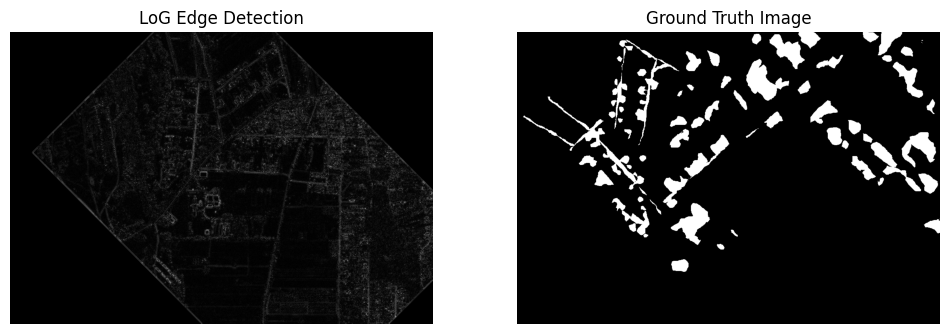

In [ ]:
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Take top 10% matches
good_matches = matches[:int(len(matches)*0.4)]

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply LoG edge detection
    edges = cv2.GaussianBlur(registered_img_gray, (3, 3), 0)
    edges = cv2.Laplacian(edges, cv2.CV_64F)
    edges = np.uint8(np.absolute(edges))

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(edges, gt_image)
    mse_value = mse(edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(edges, cmap='gray')
    ax[0].set_title('LoG Edge Detection')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))


SSIM: 0.576451681821135
MSE: 9269.448493051748


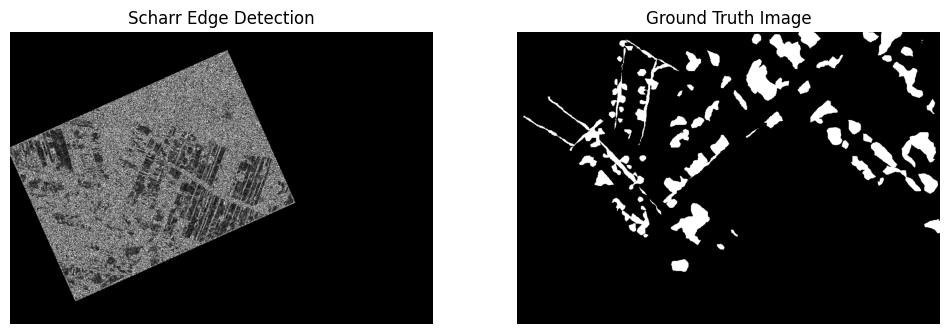

In [ ]:
import cv2
import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import matplotlib.pyplot as plt

# Load image with OpenCV
def load_image_cv(path):
    return cv2.imread(path, cv2.IMREAD_COLOR)

# Load and convert images
img1 = load_image_cv('/content/im1.bmp')
img2 = load_image_cv('/content/im2.bmp')
gt_image = io.imread('/content/gt.bmp')

# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Take top 10% matches
good_matches = matches[:int(len(matches)*0.2)]

# Ensure that sufficient matches are found
if len(good_matches) > 10:
    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Find affine transformation
    M, mask = cv2.estimateAffinePartial2D(points1, points2, method=cv2.RANSAC)

    # Warp image using affine transformation
    registered_img = cv2.warpAffine(img2, M, (img1.shape[1], img1.shape[0]))

    # Convert warped image to grayscale
    registered_img_gray = cv2.cvtColor(registered_img, cv2.COLOR_BGR2GRAY)

    # Apply Scharr edge detection
    edges_x = cv2.Scharr(registered_img_gray, cv2.CV_64F, 1, 0)
    edges_y = cv2.Scharr(registered_img_gray, cv2.CV_64F, 0, 1)
    edges = np.sqrt(edges_x**2 + edges_y**2)
    edges = np.uint8(edges)

    # Compute SSIM and MSE with ground truth
    ssim_index = ssim(edges, gt_image)
    mse_value = mse(edges, gt_image)

    print(f"SSIM: {ssim_index}")
    print(f"MSE: {mse_value}")

    # Display the processed change map and the ground truth image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(edges, cmap='gray')
    ax[0].set_title('Scharr Edge Detection')
    ax[0].axis('off')
    ax[1].imshow(gt_image, cmap='gray')
    ax[1].set_title('Ground Truth Image')
    ax[1].axis('off')
    plt.show()

else:
    print("Not enough matches - at least 10 matches required, only found", len(good_matches))
